In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import pandas_profiling
import plotly.express as px
import plotly.graph_objects as go
import sklearn.metrics as metrics

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, roc_curve,auc, confusion_matrix, classification_report

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
train_df = pd.read_csv("/kaggle/input/titanic/train.csv")
test_df = pd.read_csv("/kaggle/input/titanic/test.csv")
train_df.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [3]:
train_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [4]:
train_df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [5]:
train_df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
train_df.nunique()

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

In [7]:
train_df.count

<bound method DataFrame.count of      PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                             Allen, Mr. William Henry    male  35.0      0   
..                                  

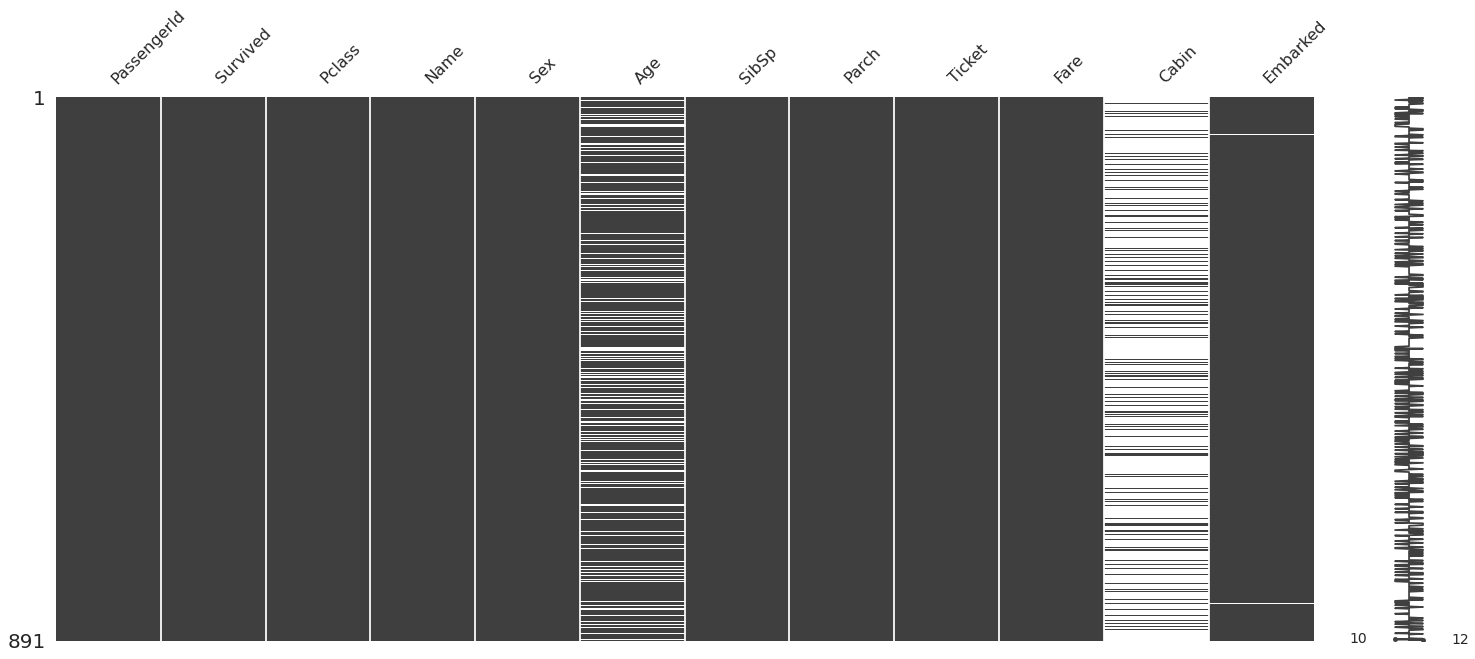

In [8]:
# visualize NaN's

msno.matrix(train_df)

In [9]:
# inspect features

profile = pandas_profiling.ProfileReport(train_df)

In [10]:
profile

/opt/conda/lib/python3.7/site-packages/IPython/core/display.py:701: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [11]:
# Create new features: 'relatives' & 'travelled alone'

data = [train_df, test_df]
for dataset in data:
    dataset['relatives'] = dataset['SibSp'] + dataset['Parch']
    dataset.loc[dataset['relatives'] > 0, 'travelled_alone'] = 'No'
    dataset.loc[dataset['relatives'] == 0, 'travelled_alone'] = 'Yes'
    
train_df['travelled_alone'].value_counts()

Yes    537
No     354
Name: travelled_alone, dtype: int64

In [12]:
# Drop 'PassengerId', because it does not affect survival probability

train_df = train_df.drop(['PassengerId'], axis=1)

In [13]:
# Engineer new feature, 'Deck', from 'Cabin'

import re
deck = {"A": "A", "B": "B", "C": "C", "D": "D", "E": "E", "F": "F", "G": "G", "U": "U"}
data = [train_df, test_df]

for dataset in data:
    dataset['Cabin'] = dataset['Cabin'].fillna("U0")
    dataset['Deck'] = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset['Deck'] = dataset['Deck'].fillna("U")

# Drop cabin feature
train_df = train_df.drop(['Cabin'], axis=1)
test_df = test_df.drop(['Cabin'], axis=1)



In [14]:
# Fill NaN values in 'Age' with random values generated using mean and std dev

data = [train_df, test_df]

for dataset in data:
    mean = train_df["Age"].mean()
    std = test_df["Age"].std()
    is_null = dataset["Age"].isnull().sum()
    # compute random numbers between the mean, std and is_null
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    # fill NaN values in Age column with random values generated
    age_slice = dataset["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset["Age"] = age_slice
    dataset["Age"] = train_df["Age"].astype(int)

In [15]:
common_value = 'S'
data = [train_df, test_df]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].fillna(common_value)

In [16]:
data = [train_df, test_df]

for dataset in data:
    dataset['Fare'] = dataset['Fare'].fillna(0)
    dataset['Fare'] = dataset['Fare'].astype(int)

In [17]:
train_df['Fare'] = train_df['Fare'].astype(int)

In [18]:
test_df['Fare'] = test_df['Fare'].astype(int)

In [19]:
# Begin the process of extracting titles

train_titles = train_df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
type(train_titles)

pandas.core.series.Series

In [20]:
# Inspect value counts for title

train_titles.value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Major         2
Mlle          2
Lady          1
Don           1
Capt          1
Mme           1
Sir           1
Jonkheer      1
Ms            1
Countess      1
Name: Name, dtype: int64

In [21]:
# Engineer new feature 'title', and map to an integer

data = [train_df, test_df]
titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

for dataset in data:
    # extract titles
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    # replace titles with a more common title or as Rare
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',\
                                            'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    # convert titles into numbers
    #dataset['Title'] = dataset['Title'].map(titles)
    # filling NaN with 0, to get safe
    dataset['Title'] = dataset['Title'].fillna("NA")
train_df = train_df.drop(['Name'], axis=1)
test_df = test_df.drop(['Name'], axis=1)

In [22]:
train_df = train_df.drop(['Ticket'], axis=1)
test_df = test_df.drop(['Ticket'], axis=1)

In [23]:
# Engineer new feature, 'Age_Class'

data = [train_df, test_df]
for dataset in data:
    dataset['Age_Class']= dataset['Age']* dataset['Pclass']



In [24]:
# Engineer new feature, "Fare_Per_Person"

for dataset in data:
    dataset['Fare_Per_Person'] = dataset['Fare']/(dataset['relatives']+1)
    dataset['Fare_Per_Person'] = dataset['Fare_Per_Person'].astype(int)

In [25]:
# Assign 'Age' to categories

data = [train_df, test_df]
for dataset in data:
    dataset['Age'] = dataset['Age'].astype(int)
    dataset.loc[ dataset['Age'] <= 2, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 2) & (dataset['Age'] <= 12), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 12) & (dataset['Age'] <= 18), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 18) & (dataset['Age'] <= 24), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 24) & (dataset['Age'] <= 45), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 45) & (dataset['Age'] <= 64), 'Age'] = 5
   # dataset.loc[(dataset['Age'] > 55) & (dataset['Age'] <= 66), 'Age'] = 6
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 6
    
    dataset['Age'] = dataset['Age'].astype(str)
    dataset.loc[ dataset['Age'] == '0', 'Age'] = "Children"
    dataset.loc[ dataset['Age'] == '1', 'Age'] = "Teens"
    dataset.loc[ dataset['Age'] == '2', 'Age'] = "Youngsters"
    dataset.loc[ dataset['Age'] == '3', 'Age'] = "Young Adults"
    dataset.loc[ dataset['Age'] == '4', 'Age'] = "Adults"
    dataset.loc[ dataset['Age'] == '5', 'Age'] = "Middle Age"
    dataset.loc[ dataset['Age'] == '6', 'Age'] = "Senior"
   # dataset.loc[ dataset['Age'] == '7', 'Age'] = "Retired"

# inspect how age is distributed
train_df['Age'].value_counts()

Adults          446
Young Adults    178
Youngsters       97
Middle Age       90
Teens            45
Children         24
Senior           11
Name: Age, dtype: int64

In [26]:
# Assign 'Fare' to categories

data = [train_df, test_df]

for dataset in data:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[(dataset['Fare'] > 31) & (dataset['Fare'] <= 99), 'Fare']   = 3
    dataset.loc[(dataset['Fare'] > 99) & (dataset['Fare'] <= 250), 'Fare']   = 4
    dataset.loc[ dataset['Fare'] > 250, 'Fare'] = 5
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    dataset['Fare'] = dataset['Fare'].astype(str)
    dataset.loc[ dataset['Fare'] == '0', 'Fare'] = "Extremely Low"
    dataset.loc[ dataset['Fare'] == '1', 'Fare'] = "Very Low"
    dataset.loc[ dataset['Fare'] == '2', 'Fare'] = "Low"
    dataset.loc[ dataset['Fare'] == '3', 'Fare'] = "High"
    dataset.loc[ dataset['Fare'] == '4', 'Fare'] = "Very High"
    dataset.loc[ dataset['Fare'] == '5', 'Fare'] = "Extremely High"

In [27]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Survived         891 non-null    int64 
 1   Pclass           891 non-null    int64 
 2   Sex              891 non-null    object
 3   Age              891 non-null    object
 4   SibSp            891 non-null    int64 
 5   Parch            891 non-null    int64 
 6   Fare             891 non-null    object
 7   Embarked         891 non-null    object
 8   relatives        891 non-null    int64 
 9   travelled_alone  891 non-null    object
 10  Deck             891 non-null    object
 11  Title            891 non-null    object
 12  Age_Class        891 non-null    int64 
 13  Fare_Per_Person  891 non-null    int64 
dtypes: int64(7), object(7)
memory usage: 97.6+ KB


In [28]:
data = [train_df, test_df]

for dataset in data:
    dataset['Pclass'] = dataset['Pclass'].astype(str)
    dataset.loc[ dataset['Pclass'] == '1', 'Pclass'] = "Class1"
    dataset.loc[ dataset['Pclass'] == '2', 'Pclass'] = "Class2"
    dataset.loc[ dataset['Pclass'] == '3', 'Pclass'] = "Class3"

In [29]:
# Capture all the numerical features so they can be scaled

train_numerical_features = list(train_df.select_dtypes(include=['int64', 'float64', 'int32']).columns)
train_numerical_features

['Survived', 'SibSp', 'Parch', 'relatives', 'Age_Class', 'Fare_Per_Person']

In [30]:
del train_numerical_features[0]
train_numerical_features

['SibSp', 'Parch', 'relatives', 'Age_Class', 'Fare_Per_Person']

In [31]:
# Feature scaling
ss_scaler = StandardScaler()
train_df_ss = pd.DataFrame(data = train_df)
train_df_ss[train_numerical_features] = ss_scaler.fit_transform(train_df_ss[train_numerical_features])

In [32]:
test_numerical_features = list(test_df.select_dtypes(include=['int64', 'float64', 'int32']).columns)
test_numerical_features

['PassengerId', 'SibSp', 'Parch', 'relatives', 'Age_Class', 'Fare_Per_Person']

In [33]:
del test_numerical_features[0]
test_numerical_features

['SibSp', 'Parch', 'relatives', 'Age_Class', 'Fare_Per_Person']

In [34]:
# Feature scaling

test_ss_scaler = StandardScaler()
test_df_ss = pd.DataFrame(data = test_df)
test_df_ss[test_numerical_features] = test_ss_scaler.fit_transform(test_df_ss[test_numerical_features])

In [35]:
# One-Hot encoding

encode_col_list = list(train_df.select_dtypes(include=['object']).columns)
for i in encode_col_list:
    train_df_ss = pd.concat([train_df_ss,pd.get_dummies(train_df_ss[i], prefix=i)],axis=1)
    train_df_ss.drop(i, axis = 1, inplace=True)

In [36]:
# One-Hot encoding

test_encode_col_list = list(test_df.select_dtypes(include=['object']).columns)
for i in test_encode_col_list:
    test_df_ss = pd.concat([test_df_ss,pd.get_dummies(test_df_ss[i], prefix=i)],axis=1)
    test_df_ss.drop(i, axis = 1, inplace=True)

In [37]:
X_train = train_df_ss.drop("Survived", axis=1)
y_train = train_df_ss["Survived"]
X_test  = test_df_ss.drop("PassengerId", axis=1).copy()

In [38]:
train_df.head()

Survived  Pclass     Sex           Age     SibSp     Parch           Fare  \
0         0  Class3    male  Young Adults  0.432793 -0.473674  Extremely Low   
1         1  Class1  female        Adults  0.432793 -0.473674           High   
2         1  Class3  female        Adults -0.474545 -0.473674  Extremely Low   
3         1  Class1  female        Adults  0.432793 -0.473674           High   
4         0  Class3    male        Adults -0.474545 -0.473674       Very Low   

  Embarked  relatives travelled_alone Deck Title  Age_Class  Fare_Per_Person  
0        S   0.059160              No    U    Mr   0.058735        -0.459218  
1        C   0.059160              No    C   Mrs  -0.768197         0.434090  
2        S  -0.560975             Yes    U  Miss   0.413135        -0.347554  
3        S   0.059160              No    C   Mrs  -0.856797         0.182847  
4        S  -0.560975             Yes    U    Mr   1.210534        -0.319638

In [39]:
test_df.head()

PassengerId  Pclass     Sex           Age     SibSp     Parch  \
0          892  Class3    male  Young Adults -0.499470 -0.400248   
1          893  Class3  female        Adults  0.616992 -0.400248   
2          894  Class2    male        Adults -0.499470 -0.400248   
3          895  Class3    male        Adults -0.499470 -0.400248   
4          896  Class3  female        Adults  0.616992  0.619896   

            Fare Embarked  relatives travelled_alone Deck Title  Age_Class  \
0  Extremely Low        Q  -0.553443             Yes    U    Mr   0.033595   
1  Extremely Low        S   0.105643              No    U   Mrs   1.230837   
2       Very Low        Q  -0.553443             Yes    U    Mr  -0.315601   
3       Very Low        S  -0.553443             Yes    U    Mr   1.006354   
4       Very Low        S   0.764728              No    U   Mrs   1.006354   

   Fare_Per_Person  
0        -0.401204  
1        -0.513662  
2        -0.344975  
3        -0.373089  
4        -0.485547

In [40]:
# Features
X = X_train 

# Target variable
y = y_train 

In [41]:
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) #, stratify=y)

In [42]:
X_train.shape, y_train.shape, X_test.shape

((891, 41), (891,), (418, 41))

In [43]:
# Classify using a Random Forrest (RF)

from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(n_estimators=100)
RF.fit(X_train,y_train)

y_pred=RF.predict(X_train)
RF_acc = metrics.accuracy_score(y_train, y_pred)

print("Accuracy:",RF_acc)

Accuracy: 0.9753086419753086


In [44]:
# Assess RF accuracy


In [45]:
# Classify using Naive Bayes (NB)

from sklearn.naive_bayes import GaussianNB

GNB = GaussianNB()
GNB.fit(X_train, y_train)
y_pred = GNB.predict(X_train)
GNB_acc = metrics.accuracy_score(y_train, y_pred)

print("Accuracy:",GNB_acc)


Accuracy: 0.7856341189674523


In [46]:
# Classify using Logisitic Regression
from sklearn.linear_model import LogisticRegression

LogReg = LogisticRegression()
LogReg.fit(X_train,y_train)

y_pred=LogReg.predict(X_train)
LogReg_acc = metrics.accuracy_score(y_train, y_pred)

print("Accuracy:",LogReg_acc)


Accuracy: 0.8473625140291807


In [47]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

LDA = LDA(n_components=1)
LDA.fit(X_train, y_train)

y_pred=LDA.predict(X_train)
LDA_acc = metrics.accuracy_score(y_train, y_pred)

print("Accuracy:",LDA_acc)

Accuracy: 0.8451178451178452


In [48]:
# Classify using XG Boost (XGB)
from xgboost import XGBClassifier

XGB = XGBClassifier()
XGB.fit(X_train, y_train)

y_pred = XGB.predict(X_train)
XGB_acc = metrics.accuracy_score(y_train, y_pred)

print("Accuracy:", XGB_acc)

Accuracy: 0.9607182940516273


In [49]:
# Tune XGB paramters using brute force

#import warnings
#warnings.filterwarnings('ignore')

#from datetime import datetime
#from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
#from sklearn.metrics import roc_auc_score
#from sklearn.model_selection import StratifiedKFold

In [50]:
# Time our brute force parameter tuning

#    if not start_time:
#        start_time = datetime.now()
#        return start_time
#    elif start_time:
#        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
#        tmin, tsec = divmod(temp_sec, 60)
#        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [51]:
# A parameter grid for XGBoost (bruteforce)

#params = {
#        'min_child_weight': [1, 5, 10],
#        'gamma': [0.5, 1, 1.5, 2, 5],
#        'subsample': [0.6, 0.8, 1.0],
#        'colsample_bytree': [0.6, 0.8, 1.0],
#        'max_depth': [3, 4, 5]
 #       }

In [52]:
#xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
#                    silent=True, nthread=1)

In [53]:
#folds = 5
#param_comb = 5

#skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1)

#random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X,y), verbose=3, random_state=1 )


#start_time = timer(None)
#random_search.fit(X, y)
#timer(start_time) 

In [54]:
#print('\n All results:')
#print(random_search.cv_results_)
#print('\n Best estimator:')
#print(random_search.best_estimator_)
#print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
#print(random_search.best_score_ * 2 - 1)
#print('\n Best hyperparameters:')
#print(random_search.best_params_)
#results = pd.DataFrame(random_search.cv_results_)
#results.to_csv('xgb-random-grid-search-results-01.csv', index=False)

In [55]:
#XGB = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#              colsample_bynode=1, colsample_bytree=1.0, gamma=1, gpu_id=-1,
#              importance_type='gain', interaction_constraints='',
#              learning_rate=0.02, max_delta_step=0, max_depth=5,
#              min_child_weight=5, monotone_constraints='()',
#              n_estimators=600, n_jobs=1, nthread=1, num_parallel_tree=1,
#              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
#              silent=True, subsample=1.0, tree_method='exact',
#              validate_parameters=1, verbosity=None)

#XGB.fit(X_train, y_train)
#y_pred = XGB.predict(X_train)
#XGB_acc = metrics.accuracy_score(y_train, y_pred)
#print("Accuracy:",XGB_acc)

In [56]:
models = pd.DataFrame({
    'Model': ['Logistic Regression', 
              'Random Forest', 'Naive Bayes','XGBoost', 'LDA'],
    'Score': [LogReg_acc, RF_acc, GNB_acc, 
              XGB_acc, LDA_acc]})
models.sort_values(by='Score', ascending=False)

Model     Score
1        Random Forest  0.975309
3              XGBoost  0.960718
0  Logistic Regression  0.847363
4                  LDA  0.845118
2          Naive Bayes  0.785634

In [57]:
submission_preds = RF.predict(X_test)

In [58]:
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": submission_preds
    })
submission.to_csv('submission.csv', index=False)

In [59]:
#        TO 
#                BE 
#                        CONTINUED......